In [1]:
# pyrates imports
from pyrates.utility.visualization import plot_timeseries, plot_connectivity, create_cmap
from pyrates.utility.grid_search import grid_search
from pyrates.utility.data_analysis import fft

# additional imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# plot settings
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 28
mpl.rcParams['ytick.labelsize'] = 28
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['legend.fontsize'] = 20

%matplotlib inline

PyRates Jansen-Rit Model Simulations
====================================

Below, you will find the code to run the Jansen-Rit model simulations described in detail in "Gast, R. et al. (2018) PyRates - A Python framework for neural modeling and simulations on parallel hardware". These simulations test the correct dynamic behavior of a single Jansen-Rit model for a number of different model parametrizations. The Jansen-Rit model is a simple 3-population neural mass model, initially proposed by Jansen and Rit in 1995: "Jansen & Rit (1195) ....". The PyRates model implementation can be found under templates/jansenrit.

Simulation 1: Jansen-Rit model sensitivity to changes in the global coupling strength
--------------------------------------------------------------------------------------

In the following cells, we examine the relationship between changes in the global coupling strength c and the dynamic behavior of the Jansen-Rit model. Thereby, c scales the connections between the 3 populations of the Jansen-Rit model (pyramidal cells, excitatory interneurons, inhibitory interneurons). The dynamic behavior of the Jansen-Rit model is operationalized via the average membrane potential time traces of the pyramidal cells. Model parameters and simulation configuration follow Jansen & Rit (1995). 

1) Parameter definition:  In the following cell, the different conditions and basic simulation parameters are defined.

In [2]:
dt = 1e-4                                                       # integration step-size of the forward euler solver in s
T = 3.                                                          # overall simulation time in s
C = np.array([68., 128., 135., 270., 675., 1350.])              # global connection weight scaling
inp = np.random.uniform(120., 320., (int(T/dt), 1))             # white noise input to the pyramidal cells in Hz.
dts = 1e-3                                                      # variable storage sub-sampling step size in s

params = {'c_pe': [], 'c_pi': [], 'c_ep': [], 'c_ip': []}       # connection weights that should be changed in each condition
param_map = {'c_pe': {'vars': ['weight'],                        # mapping between the variable names in params and the corresponding model parameters
                      'edges': [('PC', 'EIN')]},
             'c_pi': {'vars': ['weight'], 
                      'edges': [('PC', 'IIN')]},
             'c_ep': {'vars': ['weight'], 
                      'edges': [('EIN', 'PC')]},
             'c_ip': {'vars': ['weight'], 
                      'edges': [('IIN', 'PC')]}}

for c in C:
    params['c_pe'].append(np.round(1.0 * c, decimals=2))
    params['c_pi'].append(np.round(0.25 * c, decimals=2))
    params['c_ep'].append(np.round(0.8 * c, decimals=2))
    params['c_ip'].append(np.round(0.25 * c, decimals=2))

2) In the following cell, all conditions will be evaluated in parallel using the grid_search functionality of PyRates

In [5]:
results, params = grid_search(circuit_template="model_templates.jansen_rit.simple_jansenrit.JRC",
                              param_grid=params, param_map=param_map,
                              inputs={"PC/RPO_e_pc/u": inp}, 
                              outputs={"psp_e": "PC/RPO_e_pc/PSP", "psp_i": "PC/RPO_i/PSP"},
                              step_size=dt, simulation_time=T, permute_grid=False, sampling_step_size=dts,
                             )

Compilation Progress
--------------------
Starting automatic optimization of the network graph:
    ...nodes in the network have been vectorized.
    ...edges in the network have been vectorized.
    ...all edges have been connected to nodes.
Loading the network model into the backend:
    ...all edge operations have been translated to backend-compatible equations.
    ...all model equations have been collected from the network.
Parsing the model equations into a compute graph.
Compilation finished!

Simulation Progress
-------------------
Preparing the simulation:
    ...user-defined output variables are logged.
    ...user-defined inputs have been added to the model.
    ...the run function has been compiled.
starting the simulation.
Simulation finished!



3) Results visualization: For each condition, the time-series of the pyramidal cell's membrane potential will be plotted

Text(0.5, 6.799999999999805, 'time in s')

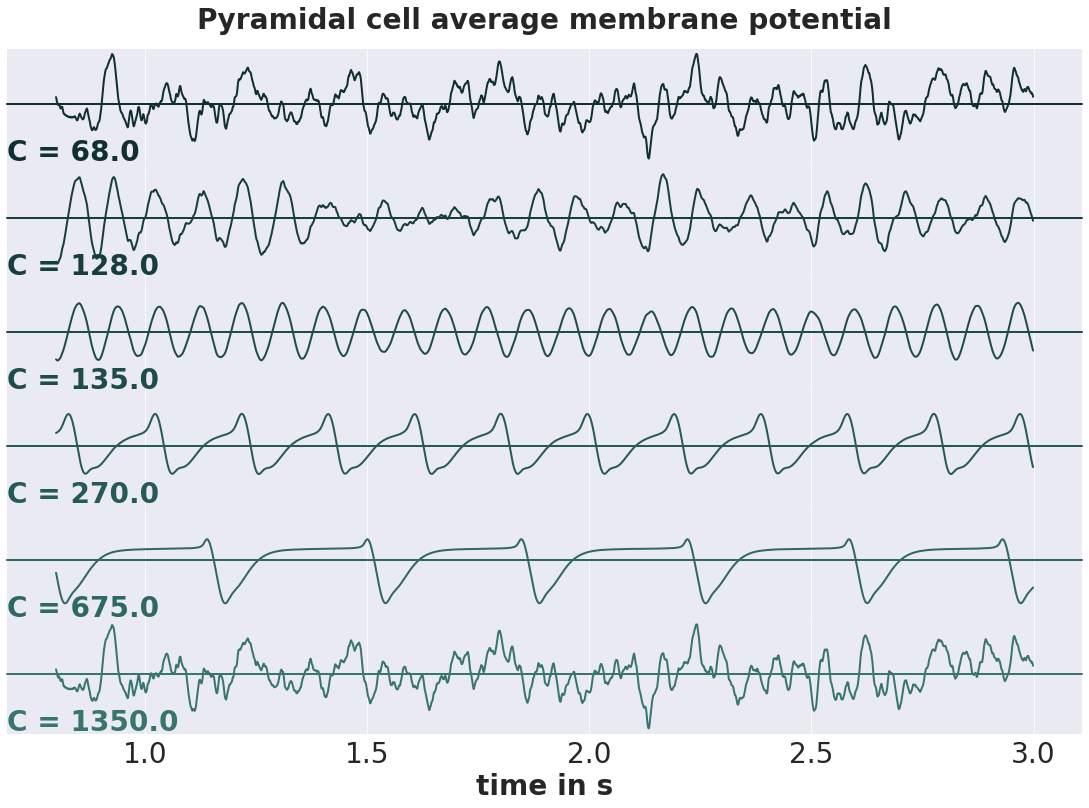

In [7]:
# calculate overall PC membrane potential from synaptic activations
potentials = results['psp_e'] + results['psp_i']

# adjust column names of results to represent the connectivity parameters
new_cols = [f"C = {params.loc[key, 'c_pe']}" for key in params.index]
potentials.columns = new_cols

# plot the timeseries
cm_red = create_cmap('pyrates_green', as_cmap=False, n_colors=16, reverse=True)
plot_timeseries(potentials.iloc[int(0.8/dts):, :], plot_style='ridge_plot', demean=True, hspace=-.01,
                fontsize=28, aspect=10, height=2.0, cmap=cm_red)

# adjust and save the figure
fig, ax = plt.gcf(), plt.gca()
fig.axes[0].set_title('Pyramidal cell average membrane potential', pad=20.)
fig.set_size_inches(16., 11.)
ax.set_xlabel('time in s')
#plt.savefig('Gast_2018_PyRates_JansenRit_C.svg', format='svg')

Simulation 2: Jansen-Rit model sensitivity to changes in the synaptic timescales
---------------------------------------------------------------------------------

In the following cells, we examine the relationship between changes in the synaptic timescales and the dynamic behavior of the Jansen-Rit model. Thereby, we systematically change the excitatory and inhibitory synaptic timescales and evaluate dynamic behavior of the Jansen-Rit model for each combination of the two. The dynamic behavior is operationalized as the response frequency band with the highest power-spectral density evaluated via the membrane potential itime traces of the pyramidal cell population. 

1) Parameter definition:  In the following cell, the different conditions and basic simulation parameters are defined.

In [8]:
# parameter definition
dt = 5e-5                                                                       # integration step-size in s
T = 10.0                                                                        # simulation time in s
tau_e = np.arange(1e-3, 63e-3, 5e-3)                                            # excitatory synaptic timescales
tau_i = np.arange(1e-3, 63e-3, 5e-3)                                            # inhibitory synaptuic timescales
inp = 220. + np.random.randn(int(T/dt), 1) * 22.                                # white noise input delivered to the pyramidal cells
params = {'tau_e': [], 'tau_i': [], 'H_e': [], 'H_i': []}                       # synaptic timescales tau and efficacies H
dts=1e-4
for t_e in tau_e:
    for t_i in tau_i:
        params['tau_e'].append(t_e)                               
        params['tau_i'].append(t_i)
        params['H_e'].append(3.25e-3*10e-3/t_e)                                
        params['H_i'].append(-22e-3*20e-3/t_i)

param_map = {'tau_e': {'vars': ['RPO_e_pc/tau', 'RPO_e/tau'], 
                       'nodes': ['PC', 'EIN', 'IIN']},
             'tau_i': {'vars': ['RPO_i/tau'], 
                       'nodes': ['PC']},
             'H_e': {'vars': ['RPO_e_pc/h', 'RPO_e/h'], 
                     'nodes': ['PC', 'EIN', 'IIN']},
             'H_i': {'vars': ['RPO_i/h'], 
                     'nodes': ['PC']}}

2) In the following cell, all conditions will be evaluated in parallel using the grid_search functionality of PyRates

In [11]:
results, params = grid_search(circuit_template="model_templates.jansen_rit.simple_jansenrit.JRC",
                              param_grid=params, param_map=param_map,
                              inputs={"PC/RPO_e_pc/u": inp}, 
                              outputs={"psp_e": "PC/RPO_e_pc/PSP", "psp_i": "PC/RPO_i/PSP"},
                              step_size=dt, simulation_time=T, permute_grid=False, sampling_step_size=dts)

Compilation Progress
--------------------
Starting automatic optimization of the network graph:
    ...nodes in the network have been vectorized.
    ...edges in the network have been vectorized.
    ...all edges have been connected to nodes.
Loading the network model into the backend:
    ...all edge operations have been translated to backend-compatible equations.
    ...all model equations have been collected from the network.
Parsing the model equations into a compute graph.
Compilation finished!

Simulation Progress
-------------------
Preparing the simulation:
    ...user-defined output variables are logged.
    ...user-defined inputs have been added to the model.
    ...the run function has been compiled.
starting the simulation.
Simulation finished!



3) 

In [12]:
# calculate overall PC membrane potential from synaptic activations
potentials = results['psp_e'] + results['psp_i']

# calculate PSDs
cut_off = 1.
max_freq = np.zeros((len(tau_i), len(tau_e)))
freq_pow = np.zeros_like(max_freq)
for key in params.index:
    t_e, t_i, h_e, h_i = params.loc[key,'tau_e'], params.loc[key,'tau_i'], params.loc[key,'H_e'], params.loc[key,'H_i']
    freqs, power = fft(potentials[key], tmin=cut_off)
    idx_c, idx_r = np.argwhere(tau_e == t_e)[0], np.argwhere(tau_i == t_i)[0]
    p = np.max(power)                                                                            
    f = freqs[np.argmax(power)]
    if p < 140.:
        if f < 4.:
            max_freq[idx_r, idx_c] = 1.
        elif f < 8.:
            max_freq[idx_r, idx_c] = 2.
        elif f < 12.:
            max_freq[idx_r, idx_c] = 3.
        elif f < 30.:
            max_freq[idx_r, idx_c] = 4.
        else:
            max_freq[idx_r, idx_c] = 5.
    else:
        max_freq[idx_r, idx_c] = 0.
    freq_pow[idx_r, idx_c] = p

4) 

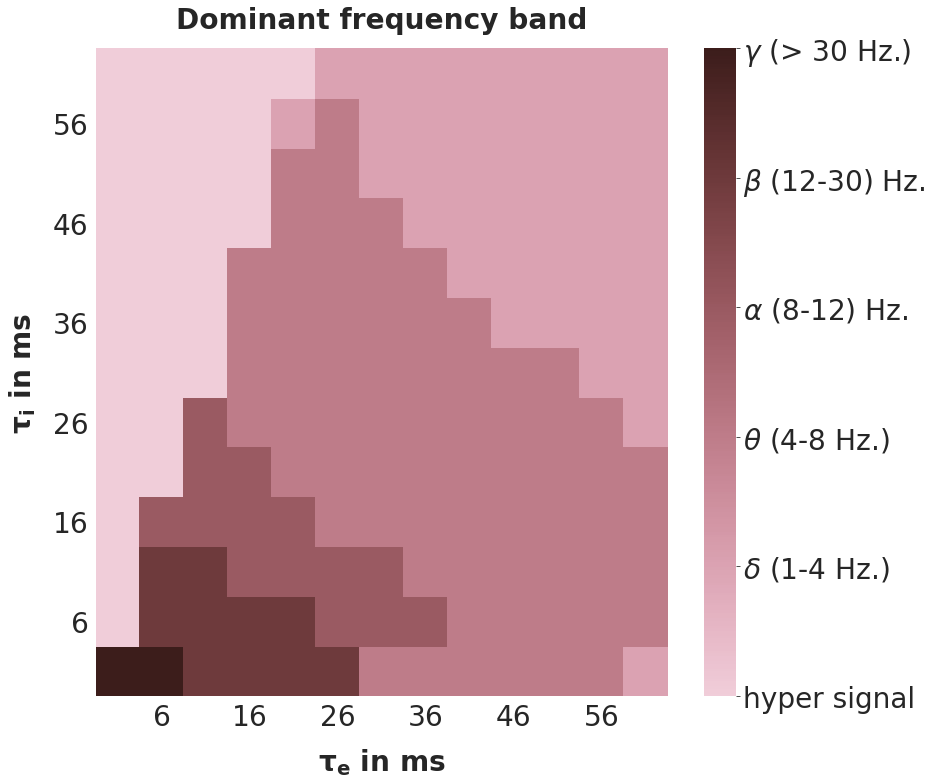

In [14]:
# create axis ticks
yticks = (tau_i * 1e3).astype('int')
yticks[::2] = 0.
yticks = [str(y) if y > 0. else '' for y in yticks]
xticks = (tau_e * 1e3).astype('int')
xticks[::2] = 0.
xticks = [str(x) if x > 0. else '' for x in xticks]

# create a color map
cm_red = create_cmap('pyrates_red', as_cmap=True)

# plot the dominant frequencies
fig, ax = plt.subplots(figsize=(13, 11))
ax = plot_connectivity(max_freq, ax=ax, yticklabels=list(yticks), xticklabels=list(xticks), cmap=cm_red)

# adjust labels
ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
ax.set_xlabel(r'$\mathbf{\tau_e}$ in ms', labelpad=15.)
ax.set_ylabel(r'$\mathbf{\tau_i}$ in ms', labelpad=15.)
ax.set_title(f'Dominant frequency band', pad=20.)
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels(['hyper signal', r'$\delta$ (1-4 Hz.)', r'$\theta$ (4-8 Hz.)', r'$\alpha$ (8-12) Hz.', 
                      r'$\beta$ (12-30) Hz.', r'$\gamma$ (> 30 Hz.)'])
ax.invert_yaxis()
plt.tight_layout()
#plt.savefig('Gast_2018_PyRates_JansenRit_taus.svg', format='svg')